## Import and Devices

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Shape Generation Functions

In [ ]:
def create_cube(size=32, cube_config=None):
    voxels = np.zeros((size, size, size), dtype=np.float32)
    if cube_config is None:
        cube_s = size // 2
    else:
        cube_s = cube_config['size']

    start = (size - cube_s) // 2
    end = start + cube_s
   
    start = max(0, start)
    end = min(size, end)
    voxels[start:end, start:end, start:end] = 1.0
    return voxels

def create_sphere(size=32, sphere_config=None):
    voxels = np.zeros((size, size, size), dtype=np.float32)
    if sphere_config is None:
        radius = size // 3
    else:
        radius = sphere_config['radius']

    center = size // 2
    for x in range(size):
        for y in range(size):
            for z in range(size):
                if (x - center)**2 + (y - center)**2 + (z - center)**2 <= radius**2:
                    voxels[x, y, z] = 1.0
    return voxels

def create_cylinder(size=32, cylinder_config=None):
    voxels = np.zeros((size, size, size), dtype=np.float32)
    if cylinder_config is None:
        radius = size // 4
        height = size // 1.5 
    else:
        radius = cylinder_config['radius']
        height = cylinder_config['height']
    
    height = int(height) 

    center = size // 2
    start_h = (size - height) // 2
    end_h = start_h + height
    
    start_h = max(0, start_h)
    end_h = min(size, end_h)

    for x_coord in range(size): 
        for y_coord in range(size): 
            if (x_coord - center)**2 + (y_coord - center)**2 <= radius**2:
                voxels[x_coord, y_coord, start_h:end_h] = 1.0
    return voxels

## 2D Slice Visualization Function

In [ ]:
def show_voxel_slice(voxel_grid, axis=2, slice_idx=None, title="Voxel Slice"):
    if slice_idx is None:
        slice_idx = voxel_grid.shape[axis] // 2
    
    plt.figure()
    if axis == 0:
        plt.imshow(voxel_grid[slice_idx, :, :], cmap='gray')
    elif axis == 1:
        plt.imshow(voxel_grid[:, slice_idx, :], cmap='gray')
    else:
        plt.imshow(voxel_grid[:, :, slice_idx], cmap='gray')
    plt.title(title)
    plt.show()

## Test Basic Shape Generation & 2D Slices

--- Testing basic shape generation and 2D slice visualization ---


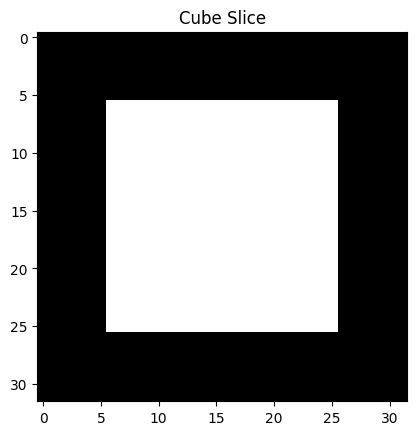

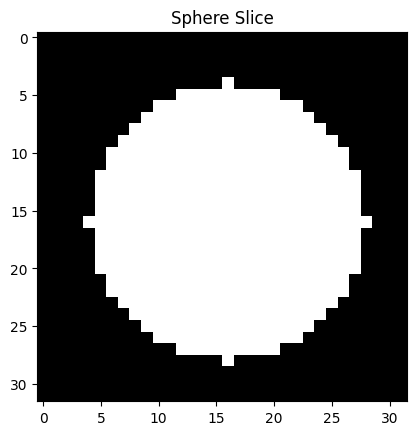

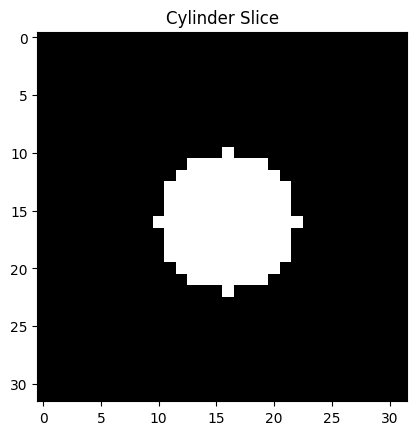

In [25]:
print("--- Testing basic shape generation and 2D slice visualization ---")
cube_test = create_cube(cube_config={'size': 20})
sphere_test = create_sphere(sphere_config={'radius': 12})
cylinder_test = create_cylinder(cylinder_config={'radius': 6, 'height': 24})

show_voxel_slice(cube_test, title="Cube Slice")
show_voxel_slice(sphere_test, title="Sphere Slice")
show_voxel_slice(cylinder_test, title="Cylinder Slice")

##  PyTorch Dataset Class for Synthetic 3D Primitives

In [ ]:
class SyntheticPrimitivesDataset(Dataset):
    def __init__(self, num_samples_per_class=100, voxel_size=32, random_params=True):
        self.voxel_size = voxel_size
        self.num_samples_per_class = num_samples_per_class
        self.total_samples = num_samples_per_class * 3  
        self.random_params = random_params
        
        self.label_map = {0: 'cube', 1: 'sphere', 2: 'cylinder'}
    
    def __len__(self):
        return self.total_samples
    
    def __getitem__(self, idx):
        class_idx = idx // self.num_samples_per_class
        
        vox = np.zeros((self.voxel_size, self.voxel_size, self.voxel_size), dtype=np.float32)

        if class_idx == 0: 
            if self.random_params:
               
                min_cube_s = max(1, self.voxel_size // 4)
                max_cube_s = max(min_cube_s + 1, int(self.voxel_size // 1.5))
                cube_s = np.random.randint(min_cube_s, max_cube_s)
                config = {'size': cube_s}
            else:
                config = None 
            vox = create_cube(size=self.voxel_size, cube_config=config)
        elif class_idx == 1: 
            if self.random_params:
                min_radius = max(1, self.voxel_size // 5)
                max_radius = max(min_radius + 1, int(self.voxel_size // 2.5))
                radius = np.random.randint(min_radius, max_radius)
                config = {'radius': radius}
            else:
                config = None
            vox = create_sphere(size=self.voxel_size, sphere_config=config)
        else:
            if self.random_params:
                min_cyl_radius = max(1, self.voxel_size // 6)
                max_cyl_radius = max(min_cyl_radius + 1, int(self.voxel_size // 3))
                cyl_radius = np.random.randint(min_cyl_radius, max_cyl_radius)

                min_height = max(1, self.voxel_size // 2)
                max_height = max(min_height + 1, int(self.voxel_size * 0.9))
                height = np.random.randint(min_height, max_height)
                config = {'radius': cyl_radius, 'height': height}
            else:
                config = None
            vox = create_cylinder(size=self.voxel_size, cylinder_config=config)
        
        vox_tensor = torch.tensor(vox, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(class_idx, dtype=torch.long)
        
        return vox_tensor, label

##  3D Convolutional Autoencoder (Voxel AE) Class

In [ ]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Conv3DAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(True),
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(True),
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(128*4*4*4, latent_dim)
        )
        
        self.decoder_fc = nn.Linear(latent_dim, 128*4*4*4)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128,4,4,4)),
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose3d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder_fc(latent)
        x_recon = self.decoder(x_recon)
        return x_recon

##  Training Loop for Voxel AE

In [ ]:
print("\n--- Training Voxel Autoencoder ---")

voxel_ae_dataset = SyntheticPrimitivesDataset(num_samples_per_class=50, voxel_size=32, random_params=True) 
voxel_ae_dataloader = DataLoader(voxel_ae_dataset, batch_size=8, shuffle=True)

voxel_ae_model = Conv3DAutoencoder(latent_dim=128).to(device)
voxel_ae_optimizer = optim.Adam(voxel_ae_model.parameters(), lr=1e-3)
voxel_ae_criterion = nn.BCELoss()

num_epochs_voxel_ae = 5 
voxel_ae_model.train()

for epoch in range(num_epochs_voxel_ae):
    running_loss = 0.0
    for batch_voxels, _ in voxel_ae_dataloader: 
        batch_voxels = batch_voxels.to(device)
        voxel_ae_optimizer.zero_grad()
        outputs = voxel_ae_model(batch_voxels)
        loss = voxel_ae_criterion(outputs, batch_voxels)
        loss.backward()
        voxel_ae_optimizer.step()
        running_loss += loss.item() * batch_voxels.size(0)
    
    epoch_loss = running_loss / len(voxel_ae_dataset)
    print(f"Voxel AE - Epoch [{epoch+1}/{num_epochs_voxel_ae}], Loss: {epoch_loss:.4f}")

print("Voxel AE Training finished!")


--- Training Voxel Autoencoder ---
Voxel AE - Epoch [1/5], Loss: 0.3734
Voxel AE - Epoch [2/5], Loss: 0.1358
Voxel AE - Epoch [3/5], Loss: 0.1328
Voxel AE - Epoch [4/5], Loss: 0.1334
Voxel AE - Epoch [5/5], Loss: 0.1159
Voxel AE Training finished!


##  Visualize Voxel AE Reconstruction


--- Visualizing Voxel AE Reconstruction ---
Visualizing reconstruction for a cube


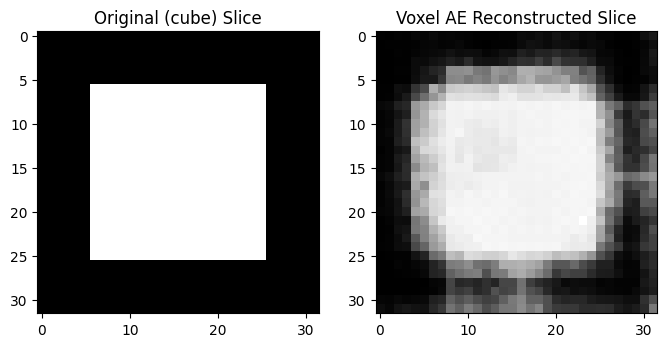

In [ ]:
print("\n--- Visualizing Voxel AE Reconstruction ---")
voxel_ae_model.eval()
with torch.no_grad():
    
    sample_idx = 0 
    if len(voxel_ae_dataset) > sample_idx:
        sample_voxels, sample_label = voxel_ae_dataset[sample_idx]  
        original_shape_type = voxel_ae_dataset.label_map[sample_label.item()]
        print(f"Visualizing reconstruction for a {original_shape_type}")

        sample_voxels_dev = sample_voxels.unsqueeze(0).to(device) 
        recon_voxels_ae = voxel_ae_model(sample_voxels_dev).cpu().squeeze(0).squeeze(0).numpy()

        fig, axs = plt.subplots(1, 2, figsize=(8,4))
        slice_idx_vis = sample_voxels.shape[-1] // 2 
        
        axs[0].imshow(sample_voxels.cpu().squeeze(0).numpy()[:, :, slice_idx_vis], cmap='gray')
        axs[0].set_title(f'Original ({original_shape_type}) Slice')
        axs[1].imshow(recon_voxels_ae[:, :, slice_idx_vis], cmap='gray')
        axs[1].set_title('Voxel AE Reconstructed Slice')
        plt.show()
    else:
        print("Not enough samples in voxel_ae_dataset to visualize.")

## Primitive Autoencoder (Parameter Prediction) Class

In [ ]:
class PrimitiveAutoencoder(nn.Module):
    def __init__(self, latent_dim=128, num_primitives=5): 
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 16, 3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv3d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*4*4*4, latent_dim),
            nn.ReLU()
        )
        
        self.num_primitives = num_primitives
        self.primitive_params = 9
        
        self.param_head = nn.Linear(latent_dim, num_primitives * self.primitive_params)

    def forward(self, x):
        latent = self.encoder(x)
        params = self.param_head(latent)
        params = params.view(-1, self.num_primitives, self.primitive_params)
        
        type_logits = params[:, :, 0:3]
        type_probs = F.softmax(type_logits, dim=-1)
        
        pos = torch.sigmoid(params[:, :, 3:6]) 
        size = torch.sigmoid(params[:, :, 6:9]) 
        
        final_params = torch.cat([type_probs, pos, size], dim=-1)
        return final_params

## Differentiable Primitive Voxel Generator Functions

In [ ]:

from packaging import version 
def generate_primitive_voxel_torch(type_probs, position, size_normalized, voxel_dim=32):
    """
    Differentiable voxel generator for a single primitive in PyTorch.
    size_normalized: tensor (3,), normalized size [0-1] (sx, sy, sz for cube, radius for sphere, rx,ry,h for cylinder)
    """
    device = type_probs.device
    coords = torch.arange(voxel_dim, device=device).float()


    if version.parse(torch.__version__) < version.parse("1.10.0"):
        
        X, Y, Z = torch.meshgrid(coords, coords, coords)
    else:
       
        X, Y, Z = torch.meshgrid(coords, coords, coords, indexing='ij')
  

    pos_vox = position * voxel_dim
  
    pos_vox = position * voxel_dim  
    dx = X - pos_vox[0]
    dy = Y - pos_vox[1]
    dz = Z - pos_vox[2]

    smoothness = 2.0 
    half_size_cube_x = (size_normalized[0] * voxel_dim) / 2.0
    half_size_cube_y = (size_normalized[1] * voxel_dim) / 2.0
    half_size_cube_z = (size_normalized[2] * voxel_dim) / 2.0
    
    cube_x = torch.sigmoid(smoothness * (half_size_cube_x - torch.abs(dx)))
    cube_y = torch.sigmoid(smoothness * (half_size_cube_y - torch.abs(dy)))
    cube_z = torch.sigmoid(smoothness * (half_size_cube_z - torch.abs(dz)))
    cube = cube_x * cube_y * cube_z

  
    sphere_radius_vox = (size_normalized[0] * voxel_dim) / 2.0
    dist_sq_sphere = dx**2 + dy**2 + dz**2
    sphere = torch.sigmoid(smoothness * (sphere_radius_vox**2 - dist_sq_sphere)) 

    
    cyl_radius_vox = (size_normalized[0] * voxel_dim) / 2.0 
    cyl_half_height_vox = (size_normalized[2] * voxel_dim) / 2.0
    
    dist_sq_cyl_xy = dx**2 + dy**2
    cyl_xy = torch.sigmoid(smoothness * (cyl_radius_vox**2 - dist_sq_cyl_xy))
    cyl_z = torch.sigmoid(smoothness * (cyl_half_height_vox - torch.abs(dz)))
    cylinder = cyl_xy * cyl_z

    voxels = (type_probs[0] * cube +
              type_probs[1] * sphere +
              type_probs[2] * cylinder)
    
    return torch.clamp(voxels, 0, 1)


def primitives_to_voxel_grid_torch(params_batch_element, voxel_dim=32):
    """
    params_batch_element: tensor (N, 9) for N primitives for a single item in batch
    """
    device = params_batch_element.device
    combined_voxels = torch.zeros((voxel_dim, voxel_dim, voxel_dim), device=device)
    num_primitives_in_sample = params_batch_element.shape[0]

    for i in range(num_primitives_in_sample):
        type_probs = params_batch_element[i, 0:3]
        position = params_batch_element[i, 3:6]
        size_params = params_batch_element[i, 6:9] 

        vox = generate_primitive_voxel_torch(type_probs, position, size_params, voxel_dim)
        combined_voxels = torch.maximum(combined_voxels, vox)
    return combined_voxels

## Training Loop for Primitive AE

In [ ]:
print("\n--- Training Primitive Autoencoder ---")

primitive_ae_dataset = SyntheticPrimitivesDataset(num_samples_per_class=50, voxel_size=32, random_params=True) 
primitive_ae_dataloader = DataLoader(primitive_ae_dataset, batch_size=4, shuffle=True) 

num_epochs_primitive_ae = 10 
learning_rate_primitive_ae = 1e-3
num_primitives_to_predict = 1 
voxel_dim_primitive_ae = 32

primitive_ae_model = PrimitiveAutoencoder(latent_dim=128, num_primitives=num_primitives_to_predict).to(device)
primitive_ae_optimizer = optim.Adam(primitive_ae_model.parameters(), lr=learning_rate_primitive_ae)
primitive_ae_loss_fn = nn.BCELoss()

primitive_ae_model.train()
for epoch in range(num_epochs_primitive_ae):
    epoch_loss = 0.0
    for i, (target_batch_voxels, _) in enumerate(primitive_ae_dataloader):
        target_batch_voxels = target_batch_voxels.to(device).float()
        
        primitive_ae_optimizer.zero_grad()
        
        pred_params_batch = primitive_ae_model(target_batch_voxels)
        
        reconstructed_batch_voxels_list = []
        for b_idx in range(pred_params_batch.shape[0]):
            
            vox_reconstructed = primitives_to_voxel_grid_torch(pred_params_batch[b_idx], voxel_dim=voxel_dim_primitive_ae) 
            reconstructed_batch_voxels_list.append(vox_reconstructed.unsqueeze(0)) 
        
        
        reconstructed_batch_voxels = torch.stack(reconstructed_batch_voxels_list, dim=0) # CORRECTED LINE
       

        loss = primitive_ae_loss_fn(reconstructed_batch_voxels, target_batch_voxels)
        loss.backward()
        primitive_ae_optimizer.step()
        
        epoch_loss += loss.item()
        if i % 10 == 0: 
             print(f"Primitive AE - Epoch [{epoch+1}/{num_epochs_primitive_ae}], Batch {i}/{len(primitive_ae_dataloader)}, Loss: {loss.item():.4f}")

    avg_epoch_loss = epoch_loss / len(primitive_ae_dataloader)
    print(f"Primitive AE - Epoch [{epoch+1}/{num_epochs_primitive_ae}], Average Loss: {avg_epoch_loss:.4f}")

print("Primitive AE Training finished!")


--- Training Primitive Autoencoder ---
Primitive AE - Epoch [1/10], Batch 0/38, Loss: 0.1620
Primitive AE - Epoch [1/10], Batch 10/38, Loss: 0.1375
Primitive AE - Epoch [1/10], Batch 20/38, Loss: 0.0751
Primitive AE - Epoch [1/10], Batch 30/38, Loss: 0.0512
Primitive AE - Epoch [1/10], Average Loss: 0.1013
Primitive AE - Epoch [2/10], Batch 0/38, Loss: 0.0826
Primitive AE - Epoch [2/10], Batch 10/38, Loss: 0.0740
Primitive AE - Epoch [2/10], Batch 20/38, Loss: 0.0573
Primitive AE - Epoch [2/10], Batch 30/38, Loss: 0.0460
Primitive AE - Epoch [2/10], Average Loss: 0.0548
Primitive AE - Epoch [3/10], Batch 0/38, Loss: 0.0563
Primitive AE - Epoch [3/10], Batch 10/38, Loss: 0.0418
Primitive AE - Epoch [3/10], Batch 20/38, Loss: 0.0778
Primitive AE - Epoch [3/10], Batch 30/38, Loss: 0.0286
Primitive AE - Epoch [3/10], Average Loss: 0.0479
Primitive AE - Epoch [4/10], Batch 0/38, Loss: 0.0453
Primitive AE - Epoch [4/10], Batch 10/38, Loss: 0.0277
Primitive AE - Epoch [4/10], Batch 20/38, Lo

## 3D Voxel Plotting Function

In [ ]:
def plot_voxel_3d(voxel_grid, threshold=0.5, title="Voxel Grid"):
    if isinstance(voxel_grid, torch.Tensor):
        voxel_grid = voxel_grid.detach().cpu().numpy()

    voxel_grid = voxel_grid.squeeze() 
    voxels_to_plot = voxel_grid > threshold

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxels_to_plot, edgecolor='k')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)
    plt.show()

## Visualize Primitive AE Reconstruction (Original and Reconstructed)


--- Visualizing Primitive AE Reconstruction ---
Visualizing Primitive AE reconstruction for a cube


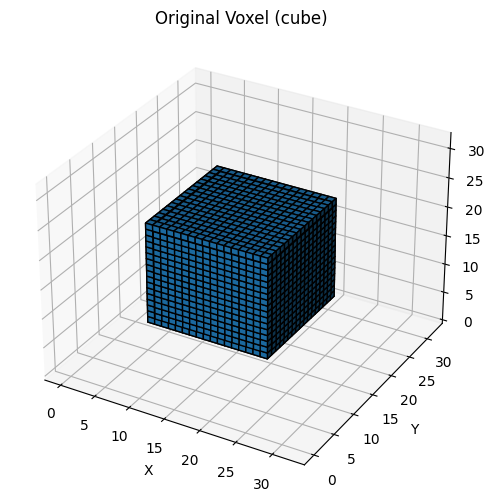

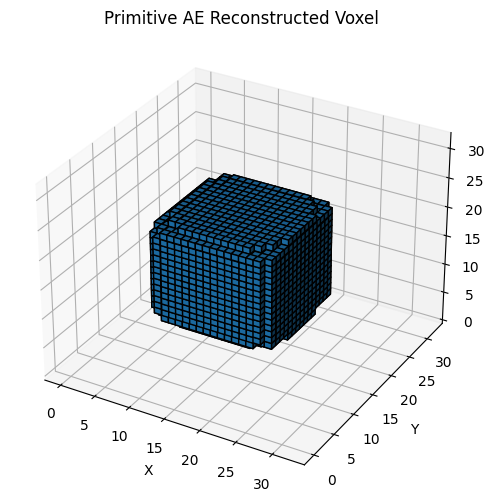


Predicted Parameters for the first primitive slot:
  Type Probs: [0.76828927 0.0488021  0.18290865]
  Position (norm): [0.47459236 0.4695659  0.47034502]
  Size (norm): [0.5426003  0.53162473 0.51581645]
  Predicted Type: cube


In [ ]:
print("\n--- Visualizing Primitive AE Reconstruction ---")
primitive_ae_model.eval()
with torch.no_grad():
   
    sample_idx_primitive = 0 
    if len(primitive_ae_dataset) > sample_idx_primitive:
        original_voxel_primitive, prim_label = primitive_ae_dataset[sample_idx_primitive] 
        original_shape_type_prim = primitive_ae_dataset.label_map[prim_label.item()]
        print(f"Visualizing Primitive AE reconstruction for a {original_shape_type_prim}")

        original_voxel_primitive_dev = original_voxel_primitive.unsqueeze(0).to(device).float() 
        
      
      
        pred_params_single = primitive_ae_model(original_voxel_primitive_dev) 
        
        reconstructed_voxel_primitive = primitives_to_voxel_grid_torch(pred_params_single[0], voxel_dim=voxel_dim_primitive_ae)

       
        plot_voxel_3d(original_voxel_primitive, title=f"Original Voxel ({original_shape_type_prim})")

        
        plot_voxel_3d(reconstructed_voxel_primitive, title="Primitive AE Reconstructed Voxel")

       
        if num_primitives_to_predict > 0:
            print("\nPredicted Parameters for the first primitive slot:")
            params_to_print = pred_params_single[0, 0, :].cpu().numpy()
            print(f"  Type Probs: {params_to_print[0:3]}")
            print(f"  Position (norm): {params_to_print[3:6]}")
            print(f"  Size (norm): {params_to_print[6:9]}")
            predicted_type_idx = np.argmax(params_to_print[0:3])
            print(f"  Predicted Type: {primitive_ae_dataset.label_map.get(predicted_type_idx, 'Unknown')}")

    else:
        print("Not enough samples in primitive_ae_dataset to visualize.")